In [1]:
library(SummarizedExperiment)
library(RColorBrewer)
library(plyr)
library(dplyr)
library(parallel)
library(ggplot2)
library(goseq)
library(stringr)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)
library(wordcloud)
library(plotrix)
library(DESeq2)

Warning message:
“package ‘SummarizedExperiment’ was built under R version 3.6.2”Loading required package: GenomicRanges
Warning message:
“package ‘GenomicRanges’ was built under R version 3.6.2”Loading required package: stats4
Loading required package: BiocGenerics
Warning message:
“package ‘BiocGenerics’ was built under R version 3.6.2”Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
   

In [2]:
se <- readRDS(gzcon(url('https://s3.msi.umn.edu/garry_projects/etv2_pioneer/processed_Etv2_scRNAseq.rds')))
colData(se)$group <- colData(se)$group %>% factor(c('MEF_Dox_D1', 'MEF_NoDox', 'MEF_Dox_D2', 'MEF_Dox_D7a', 'MEF_Dox_D7b'))
colData(se)$group <- revalue(colData(se)$group, c("MEF_Dox_D1"="MEF_NoDox", "MEF_NoDox"="MEF_Dox_D1"))
invalid <- assays(se)$counts[rowData(se)$name == 'Etv2', ] > 0 & colData(se)$group == 'MEF_NoDox' 
se <- se[, !invalid]
table(colData(se)$group)


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3562         948        2936        7202         827 


  MEF_NoDox  MEF_Dox_D1  MEF_Dox_D2 MEF_Dox_D7a MEF_Dox_D7b 
       3539         948        2936        7202         827 

Show a list of genes that are 
(1) highly expressed in MEF reprogramming Day 7 (compared with the remaining cells) (pvalue < 1e-10) and 
(2) very low expression in MEF (mean normalized expression levels < 0.01).  
These genes will be used to examine the transcripts in Brg1KD MEF at D7.  

In [4]:
X <- assays(se)$scaled_counts
pvalues <- mclapply(
  1:nrow(X), function(i) 
    wilcox.test(
      X[i, colData(se)$group == 'MEF_Dox_D7b'], 
      X[i, colData(se)$group != 'MEF_Dox_D7b'], 
      alternative = 'greater'
    )$p.value,
  mc.cores = 4) %>% 
  unlist()

In [8]:
X <- assays(se)$normalized_counts
rownames(X) <- rowData(se)$name
gs <- rownames(X)[pvalues < 1e-10 & rowMeans(X[, colData(se)$group == 'MEF_NoDox']) < 0.01]

In [7]:
d <- do.call('rbind', lapply(gs, function(g){
   x <- X[g, ]
   data.frame(
     gene = g, 
     expression = x,
     stage = colData(se)$group
   )
}))

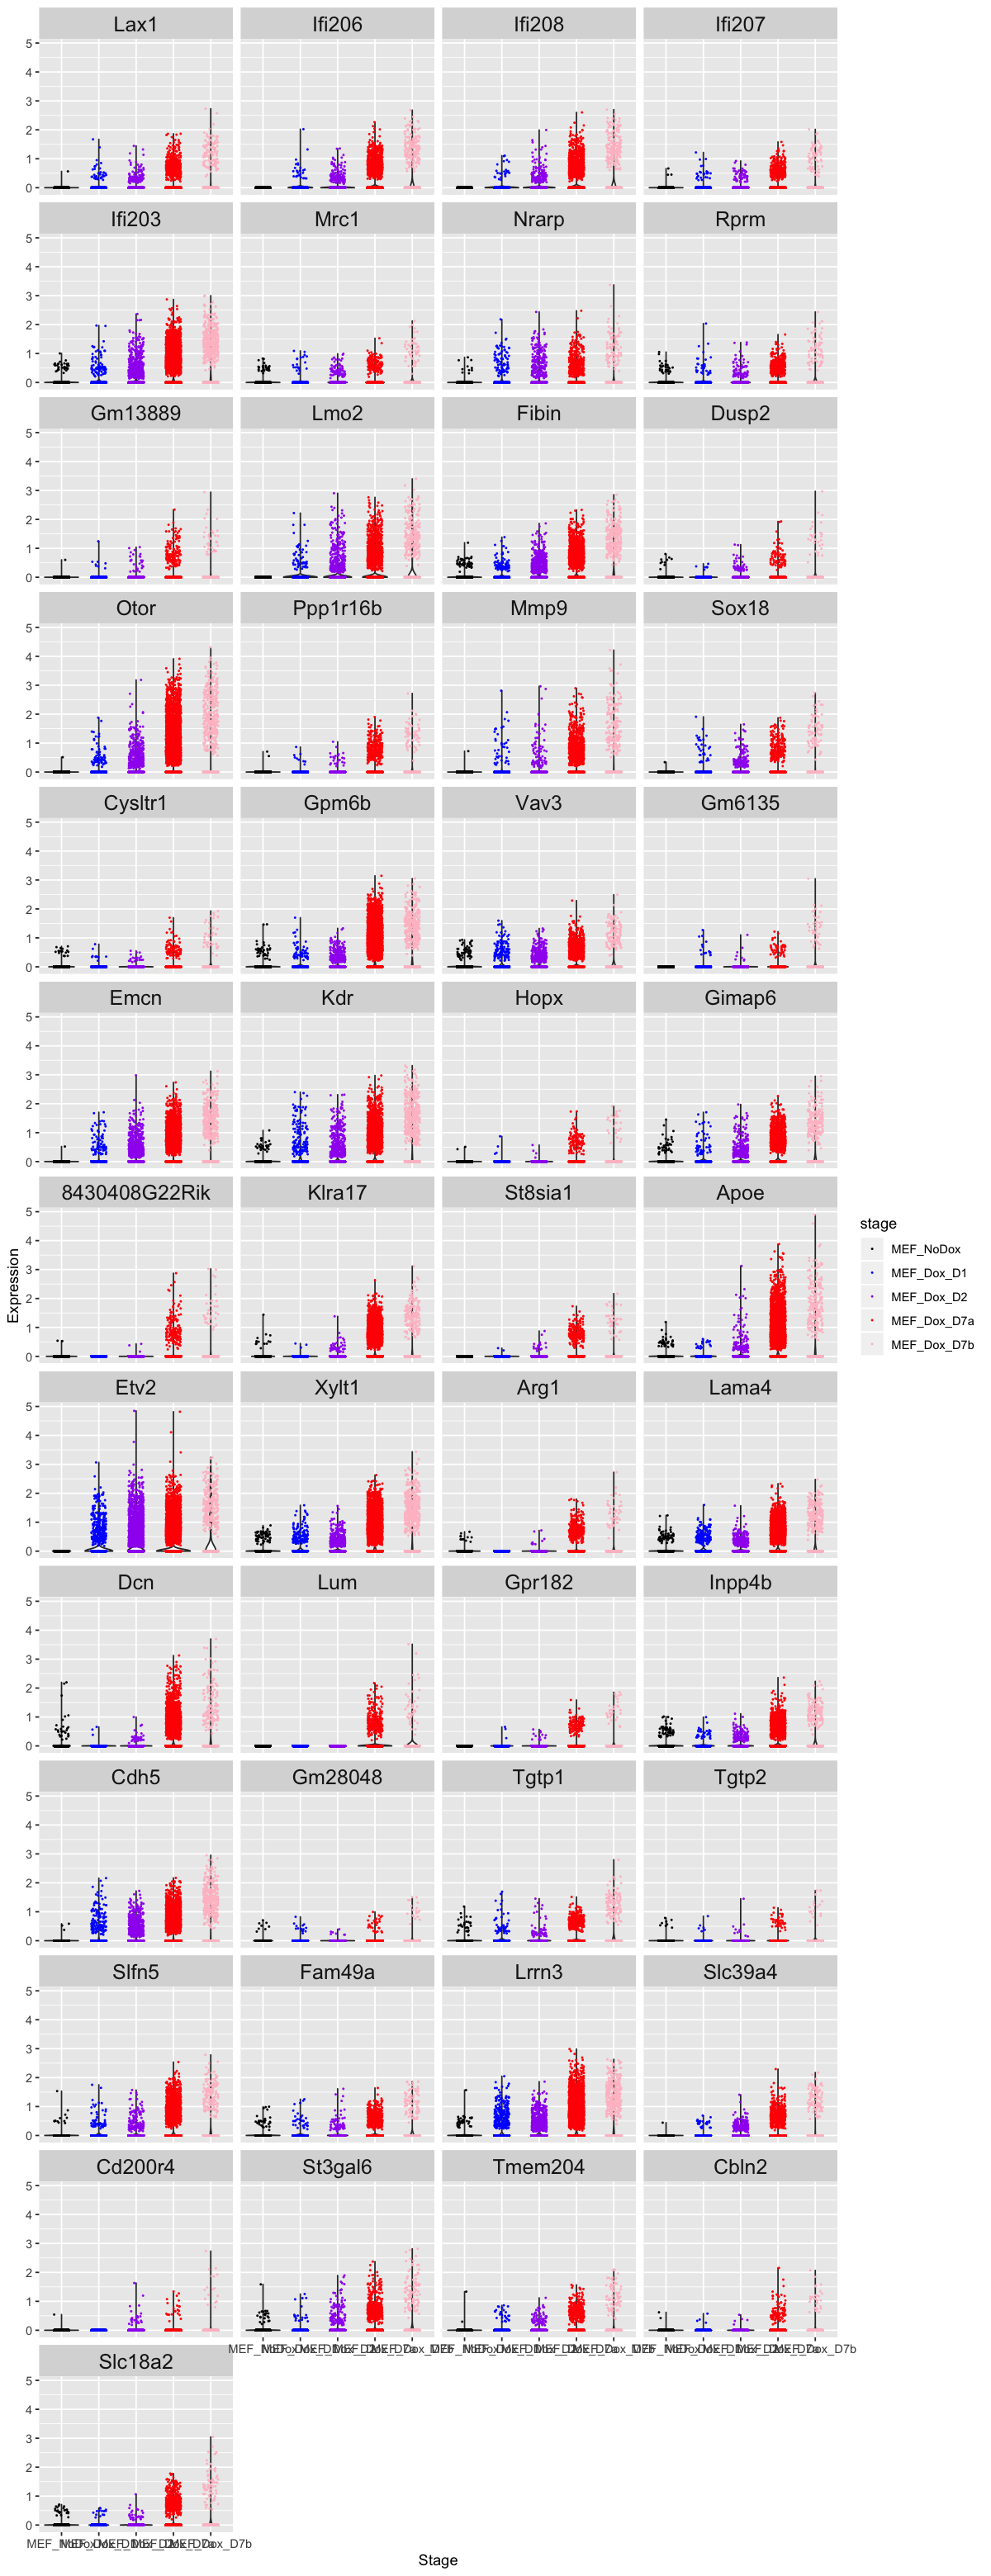

In [10]:
options(repr.plot.width=10, repr.plot.height = ceiling(length(gs) / 4) * 2)
group2bg <- c(
   'MEF_NoDox' = 'black',
   'MEF_Dox_D1' = 'blue',
   'MEF_Dox_D2' = 'purple',
   'MEF_Dox_D7a' = 'red',
   'MEF_Dox_D7b' = 'pink'
)
d %>%
  ggplot(aes(x = stage, y = expression)) + 
  geom_violin() +
  geom_jitter(shape=16, position=position_jitter(0.2), size = 0.5, aes(color = stage)) +
  facet_wrap(~ gene, ncol = 4) +
  scale_color_manual(values=group2bg) +
  theme(strip.text = element_text(size=15)) +
  ylab('Expression') + xlab('Stage')


In [11]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.2

Matrix products: default
BLAS/LAPACK: /Users/gongx030/anaconda3/envs/r/lib/libopenblasp-r0.3.7.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.26.0                            
 [2] plotrix_3.7-7                            
 [3] wordcloud_2.6                            
 [4] org.Mm.eg.db_3.10.0                      
 [5] TxDb.Mmusculus.UCSC.mm10.knownGene_3.10.0
 [6] GenomicFeatures_1.38.1                   
 [7] AnnotationDbi_1.48.0                     
 [8] stringr_1.4.0                            
 [9] goseq_1.38.0                             
[10] geneLenDataBase_1.22.0                   
[11] BiasedUrn_1.07                           
[12] ggplot2_3.2.1                           